In [3]:
import pandas as pd
import numpy as np 

In [4]:
DATA_PATH = ''
vgd_data = DATA_PATH+'video_game.csv'

In [5]:
vgd_master = pd.read_csv(vgd_data)

In [6]:
#Lets change all the names of the columns to lowercase
vgd_master.columns = vgd_master.columns.str.lower()
vgd = vgd_master
vgd.dtypes

unnamed: 0           int64
name                object
platform            object
year_of_release    float64
genre               object
publisher           object
na_players         float64
eu_players         float64
jp_players         float64
other_players      float64
global_players     float64
critic_score       float64
critic_count       float64
user_score          object
user_count         float64
developer           object
rating              object
dtype: object

In [7]:
#Before I can split I actually have to deal with NAN values
#If I have more time/if I want to come back to this I can try using an api to gather missing data 

#Target column (critic_score)
vgd = vgd.drop(vgd[vgd.critic_score.isna()].index)

#year_of_release
vgd = vgd.drop(vgd[vgd.year_of_release.isna()].index)

#rating:
vgd = vgd.drop(vgd[vgd.rating.isna()].index)

#publisher:
vgd = vgd.drop(vgd[vgd.publisher.isna()].index)

In [8]:
# I'm going to drop user_score, user_count, and critic_count columns because they are leaky.

vgd.isna().sum()

unnamed: 0            0
name                  0
platform              0
year_of_release       0
genre                 0
publisher             0
na_players            0
eu_players            0
jp_players            0
other_players         0
global_players        0
critic_score          0
critic_count          0
user_score           24
user_count         1076
developer             0
rating                0
dtype: int64

In [9]:
vgd.shape

(7901, 17)

In [10]:
#Train Test Split:
from sklearn.model_selection import train_test_split
test_size = 0.127
train, test = train_test_split(vgd,test_size = test_size)
val_size=0.15
train,val = train_test_split(train,test_size = val_size)
train.shape,val.shape,test.shape


((5862, 17), (1035, 17), (1004, 17))

In [11]:
asdfasdf = val.dropna(subset=['user_count'])
asdfasdf.user_score.astype(float)

14942    6.2
13484    2.0
3214     5.5
7785     7.9
13899    8.8
        ... 
5230     7.7
7224     7.0
3858     8.0
12994    6.8
2646     8.6
Name: user_score, Length: 893, dtype: float64

In [12]:
def wrangle(X):
    #To Avoid warning (?)
    X = X.copy()
    
    #Drop index column
    X = X.drop('unnamed: 0',1)
    
    #Drop year_of_release nans
    yor_drop = X[X.year_of_release.isna()].index.to_list()
    X = X.drop(yor_drop)
    
    #drop all nans in user count column
    X = X.dropna(subset=['user_count'])
    
    #change the type of the user_score to float 
    X.user_score = X.user_score.astype(float)
    return X

train = wrangle(train)
test = wrangle(test)
val = wrangle(val)

In [13]:
train.shape

(5067, 16)

# Exploration

TOC for explore. I made a copy of the df for each iteration, the problem with this would be memory management for much larger datasets, but I'm not sure if there are some optimizations going in the background. (querying a single database  in memory, and returning the results, or actually creating a copy to place  in memory? What is happening in the hardware?)


df:usage...


explore: plotting the difference between user and critic scores.

## User vs Critic Scores

In [14]:
import seaborn as sns

In [15]:
#User score vs critic score:
#Lets get rid of nans
explore = train
explore.shape

(5067, 16)

In [16]:
explore = explore.dropna(subset = ['user_count','critic_count'])
explore.shape

(5067, 16)

In [17]:
explore.critic_score = explore.critic_score/10

In [18]:
explore.user_score = explore.user_score.astype(float)

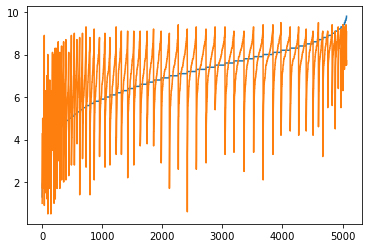

In [19]:
x = list(range(len(explore)))
y1 = explore.critic_score.to_list()
y2 = explore.user_score.to_list()

y1, y2 = zip(*sorted(zip(y1,y2)))

# the other way to do this is probably through sortby in pandas

sns.lineplot(x = x, y = y1, data= explore)
sns.lineplot(x = x, y = y2, data = explore)

This tells me that user and critic scores don't really track. This may be due to a bias in the way that these scores are collected. 

I would guess that on average the closer a game is to average the better the scores line up compared to the ends

It does seem like every "step" of a crtitic_score has a range of possible values for user_score. I can look at the spread of user for every critic, and see if I can glean some information from that.  (I do this below)

This does provide an interesting feature for a different model/ maybe one for this model. We could look at if the critic score, and the user score match for specific games. And we could set that as the target for the model. This model would then produce the boolean/number that describes the difference between critic score and normal score, and then it could be used in another model to predict the critic score. You wouldn't have leakage because each model is still working on the base input information. I also don't think that the value would be a huge predictor because the error associated with the first model would be noise in the second model. The feature wouldn't track perfectly becuase the value that its using is an imperfect value. If there is a manual way to tone down the effects of that specific feature I could also ensure that the feature isn't overused by dampening the effects of my "engineered" feature in the model.

In [20]:
#Pandas sortby test:
explore.sort_values("critic_score").head()
#From here I can just take critic score, and user score turn them into lists
#and send them to my graphing function. Might be more memory efficient my previous 
#way.

,name,platform,year_of_release,genre,publisher,na_players,eu_players,jp_players,other_players,global_players,critic_score,critic_count,user_score,user_count,developer,rating
13690,Ride to Hell,PS3,2013.0,Racing,Deep Silver,0.02,0.01,0.0,0.01,0.04,1.3,4.0,1.0,218.0,"Eutechnyx, Deep Silver",M
10663,Leisure Suit Larry: Box Office Bust,PS3,2009.0,Adventure,Codemasters,0.06,0.03,0.0,0.01,0.10,1.7,11.0,1.7,37.0,Team 17,M
12823,Ride to Hell,X360,2013.0,Racing,Deep Silver,0.04,0.01,0.0,0.01,0.06,1.9,14.0,1.3,433.0,"Eutechnyx, Deep Silver",M
15345,Balls of Fury,Wii,2007.0,Sports,Zoo Digital Publishing,0.02,0.00,0.0,0.00,0.02,1.9,6.0,2.8,25.0,Black Lantern Studios,E10+
10016,Rugby 15,PS4,2015.0,Sports,Bigben Interactive,0.04,0.06,0.0,0.02,0.11,1.9,5.0,3.4,65.0,HB Studios Multimedia,E


In [21]:
explore.critic_score.unique().shape 
#There are only 80 "steps" to the graph. 

(81,)

In [22]:
critic_score_values = sorted(explore.critic_score.unique())
# critic_score_values

In [23]:
type(critic_score_values[0])

numpy.float64

In [24]:
critic_score_value = 1.9
mask = explore.critic_score==critic_score_value
mask
a = explore[mask]

In [25]:
amean = a.user_score.mean()
amean

2.98

In [26]:
astd= a.user_score.std()
astd

1.0940749517286281

### User/Critic difference graph

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# critic_score_values

In [29]:
ameans = []
astds = []
for my_value in critic_score_values:
    mask = explore.critic_score == my_value
    a = explore[mask]
    amean = a.user_score.mean()
    astd = a.user_score.std()
    ameans.append(amean)
    astds.append(astd)
graph_zip = list(zip(critic_score_values,ameans,astds))

#slice doesn't work well here beacause I have a list of tuples not a list of lists
#but I can see that I have reasonable values by uncommenting the following:
# graph_zip

In [30]:
#plus and minus one std from mean
p1_std = list(np.array(ameans)+np.array(astds))
m1_std = list(np.array(ameans)-np.array(astds))
x = list(range(len(ameans)))

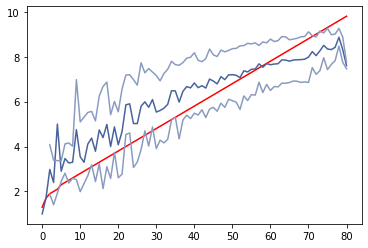

In [31]:
sns.lineplot(x,critic_score_values, color= 'red')
sns.lineplot(x,ameans, color = '#48639c')
# sns.lineplot(x,astds)
sns.lineplot(x,p1_std,color = '#8a9bc0')
sns.lineplot(x,m1_std,color = '#8a9bc0')
#Add a distribution on top of this to describe number of 
#values used to caluclate the mean
#Plot 1 : Less scores in the lower end of scores <- historgram plot
#Plot 2 the plot below:
#Scatter plot user on 1 axis and critic on another axis (use alpha/opacity) (apply some jitter?< gets rid of overlapping points for non-continousu variables)
#bivariant distribitions in seaborn (hexbin plot<-- try this?)

The above graph shows the relationship between critic scores (blue) and user scores (darker orange) along with +- 1 standard deviation from the user scores (lighter orange). Notice that on average user scores are higher for ratings below around 7/10, and lower for ratings above 7/10. Now this could be for a statistical reason. There are simply fewer scores below 6 than there are above 6 so there is more uncertainty associated with lower user scores. This uncertainty is reflected in the standard deviation curves. Aside from this bias the data can also be interpereted as follows. It seems like the games that critics love, the games that score the best according to critics are not appreciated by users. This could be for a variety of reasons. In some cases it may be that the "hype" for the game was overdone, leading to high expectations. When those expectations weren't met the 

Now I'm not completely sure which of these reasons is the truth, but if reason () is true that would mean that a truly great game should be given a slightly lower score in order to attract more users? 
Personally I have sometimes felt that the games I was supposed to like, the games that were "classics" didn't live up to my expectations, oftentimes the games I enjoy the most are the games that are unexpectedly good. Part of their value lies in the discovery of the game. My brain doesn't judge while I play, it just absorbs, and that makes the experience better for me.

### Histograms

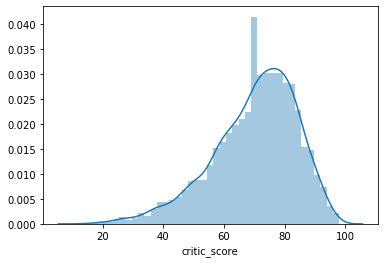

In [32]:
sns.distplot(train.critic_score)

In [33]:
#User score is an object so I have to change that before 
print(train.critic_score.dtype)
print(train.user_score.dtype) # O = object

float64
float64


In [34]:
#interesting that these two are different:
print(train.user_score.dtype) 
train.user_score.dtype

float64


dtype('float64')

In [35]:
print(train.user_score.shape)
mask = train.user_score=="tbd"
print(train.user_score[~mask].shape)
user_score_float = train.user_score[~mask].dropna().astype(float)*10

(5067,)
(5067,)


G:\Apps\Anaconda3\envs\u2build\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [36]:
user_score_float

3199     84.0
9571     67.0
11219    76.0
4459     86.0
12545    81.0
         ... 
6432     85.0
1251     73.0
173      73.0
1961     71.0
1413     82.0
Name: user_score, Length: 5067, dtype: float64

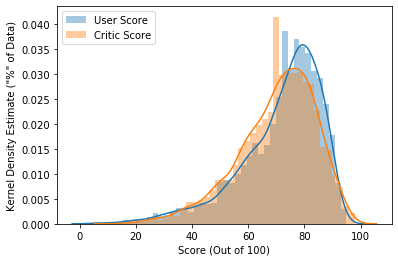

In [37]:
sns.distplot(user_score_float,label='User Score')
#adding the critic score to this user score:
ax = sns.distplot(train.critic_score,label='Critic Score')
ax.legend()
ax.set_xlabel('Score (Out of 100)')
ax.set_ylabel('Kernel Density Estimate ("%" of Data)')
plt.show()


Hypothesis testing would tell me if this difference between critics and users is due to randomness or not. 

### Scatter Plots:

In [38]:
#lets use the mask I made to make the critic and user the same length:
mask = train.user_score=="tbd"
user_score_float = train.user_score[~mask].dropna().astype(float)*10
critic_score_masked = train.critic_score[~mask]

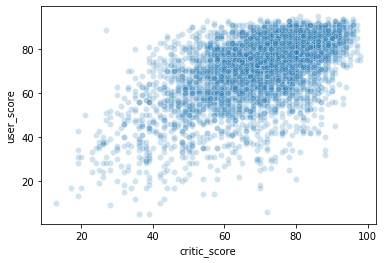

In [39]:
#now we can plot them against each other:
sns.scatterplot(critic_score_masked,user_score_float,alpha = 0.2)

### Experiment to use more seaborn features

In [40]:
#I can just drop user_count = NAN
print(train.shape)
train_scatter = train.dropna(subset=['user_count'])
train_scatter.shape

(5067, 16)


(5067, 16)

In [41]:
#create a scaled user score column
train_scatter['user_score_scaled'] = train_scatter.user_score*10

In [42]:
# fig,ax = plt.subplots()
# sns.scatterplot('critic_score','user_score_scaled',data = train_scatter,ax=ax);
# ax.get_ylabel()
#I have to fix the ylabels in the graph

In [43]:
train.head()

,name,platform,year_of_release,genre,publisher,na_players,eu_players,jp_players,other_players,global_players,critic_score,critic_count,user_score,user_count,developer,rating
3199,Ape Escape 2,PS2,2002.0,Platform,Sony Computer Entertainment,0.12,0.09,0.38,0.03,0.63,82.0,31.0,8.4,32.0,SCE Japan Studio,E
9571,Portal Runner,PS2,2001.0,Platform,3DO,0.06,0.05,0.00,0.02,0.13,53.0,18.0,6.7,6.0,3DO,E
11219,Top Gear Rally,GBA,2003.0,Racing,Kemco,0.06,0.02,0.00,0.00,0.09,78.0,12.0,7.6,5.0,Tantalus Interactive,E
4459,NFL Blitz 20-03,PS2,2002.0,Sports,Midway Games,0.21,0.17,0.00,0.06,0.44,73.0,15.0,8.6,5.0,Point of View,E
12545,Flipnic: Ultimate Pinball,PS2,2003.0,Misc,Ubisoft,0.03,0.02,0.00,0.01,0.06,64.0,28.0,8.1,12.0,SCEI,E


#  User Scores Model:

In [44]:
#Setting up matrices for models:

target = 'user_score'
#the first three are leaky and the rest are high cardinality.
drop = ['critic_count','critic_score','user_count','name','publisher','developer']
features = train.columns.drop(target)
features = features.drop(drop)
features

Index(['platform', 'year_of_release', 'genre', 'na_players', 'eu_players',
       'jp_players', 'other_players', 'global_players', 'rating'],
      dtype='object')

In [45]:
X_train = train[features]
y_train = train[target]
y_train_user = y_train

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

#Some verification:
train.shape,X_train.shape

((5067, 16), (5067, 9))

In [46]:
y_val

14942    6.2
13484    2.0
3214     5.5
7785     7.9
13899    8.8
        ... 
5230     7.7
7224     7.0
3858     8.0
12994    6.8
2646     8.6
Name: user_score, Length: 893, dtype: float64

# Baseline

In [47]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

X_train.head()
y_baseline = [y_train.mean()]*len(y_val)

print(f'Mean absolute error: {mae(y_val,y_baseline)}')
print(f'R2 score: {r2_score(y_val,y_baseline)}')

Mean absolute error: 1.0953179024807775
R2 score: -0.0033943917533607593


# Model 1 (Tree Based Regression)

In [48]:
#High cardinality columns... might have to get rid of them or process them somehow.
# print('Uniques in "developer" column',len(train.developer.unique()))
# train.developer.unique()

# print('Uniques in "publisher" column',len(train.publisher.unique()))
# train.publisher.unique()

In [49]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

process = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
)

X_train_processed = process.fit_transform(X_train)
X_val_processed = process.transform(X_val)

model = RandomForestRegressor(
    n_jobs = -2,
    n_estimators=100,
    criterion='mae',
    )

model.fit(X_train_processed,y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [50]:
print('Training Error:', model.score(X_train_processed,y_train))
print('Validation Error:',model.score(X_val_processed,y_val))

Training Error: 0.8559932695667096
Validation Error: 0.09263392865357367


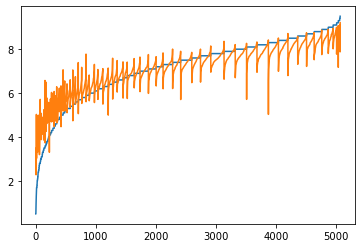

In [51]:
import seaborn as sns
#Visual Error observation:

a = y_train
p = model.predict(X_train_processed)
x = list(range(len(y_train)))

a1,p1 = zip(*sorted(zip(a,p)))

sns.lineplot(x,a1)
sns.lineplot(x,p1)


In [52]:
import shap

def shap_plot(row_number):
    row = X_train.iloc[[row_number]]
    row_processed = process.transform(row)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row_processed)
    
    shap.initjs()
    
    return shap.force_plot(
        base_value = explainer.expected_value,
        shap_values = shap_values,
        features = row,
    )

shap_plot(3972)

In [53]:
critic_score_predictions = model.predict(X_train_processed)
critic_score_predictions.shape

(5067,)

## Model 2 (Linear Regression)

In [54]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

process = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
)

X_train_processed = process.fit_transform(X_train)
X_val_processed = process.transform(X_val)

model = LinearRegression(
    n_jobs = -2,
    )

model.fit(X_train_processed,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-2, normalize=False)

In [55]:
print('Training Error:', model.score(X_train_processed,y_train))
print('Validation Error:',model.score(X_val_processed,y_val))

Training Error: 0.08891407766252934
Validation Error: 0.08069304774979835


In [56]:
list(zip(X_train.columns,model.coef_))

[('platform', 0.0012600626786788),
 ('year_of_release', -0.09028742512505301),
 ('genre', 0.022600539372722734),
 ('na_players', 1.8877233611105468),
 ('eu_players', 1.6206496891773552),
 ('jp_players', 2.3505346739889816),
 ('other_players', 1.9291034170578067),
 ('global_players', -1.7838601496037625),
 ('rating', 0.07214633256449199)]

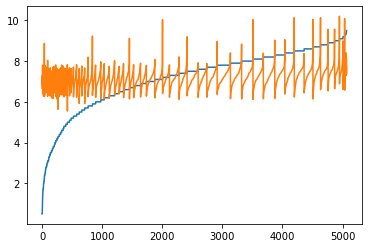

In [57]:
import seaborn as sns
#Visual Error observation:

a = y_train
p = model.predict(X_train_processed)
x = list(range(len(y_train)))

a1,p1 = zip(*sorted(zip(a,p)))

sns.lineplot(x,a1)
sns.lineplot(x,p1)

# Guessing Critic Scores

In [58]:
target = 'critic_score'
#the first three are leaky(ish) and "name" is high cardinality.
drop = ['critic_count','user_score','user_count','name','publisher','developer']
features = train.columns.drop(target)
features = features.drop(drop)
features

Index(['platform', 'year_of_release', 'genre', 'na_players', 'eu_players',
       'jp_players', 'other_players', 'global_players', 'rating'],
      dtype='object')

In [59]:
X_train = train[features]
y_train = train[target]
y_train_critic = y_train

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

#Some verification:
train.shape,X_train.shape

((5067, 16), (5067, 9))

# Baseline

In [60]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

X_train.head()
y_baseline = [y_train.mean()]*len(y_val)

print(f'Mean absolute error: {mae(y_val,y_baseline)}')
print(f'R2 score: {r2_score(y_val,y_baseline)}')

Mean absolute error: 11.275359455413914
R2 score: -0.001876305930948341


# Model 1 (Tree Based Regression)

In [61]:
#High cardinality columns... might have to get rid of them or process them somehow.
# print('Uniques in "developer" column',len(train.developer.unique()))
# train.developer.unique()

# print('Uniques in "publisher" column',len(train.publisher.unique()))
# train.publisher.unique()

In [62]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

process = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
)

X_train_processed = process.fit_transform(X_train)
X_val_processed = process.transform(X_val)

model = RandomForestRegressor(
    n_jobs = -2,
    n_estimators=100,
    criterion='mae',
    )

model.fit(X_train_processed,y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [63]:
print('Training Error:', model.score(X_train_processed,y_train))
print('Validation Error:',model.score(X_val_processed,y_val))

Training Error: 0.8853916105369568
Validation Error: 0.3076252919160448


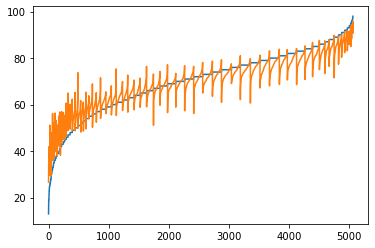

In [64]:
import seaborn as sns
#Visual Error observation:

a = y_train
p = model.predict(X_train_processed)
x = list(range(len(y_train)))

a1,p1 = zip(*sorted(zip(a,p)))

sns.lineplot(x,a1)
sns.lineplot(x,p1)


In [65]:
import shap

def shap_plot(row_number):
    row = X_train.iloc[[row_number]]
    row_processed = process.transform(row)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row_processed)
    
    shap.initjs()
    
    return shap.force_plot(
        base_value = explainer.expected_value,
        shap_values = shap_values,
        features = row,
    )

shap_plot(3972)

In [66]:
user_score_predictions = model.predict(X_train_processed)
user_score_predictions.shape

(5067,)

# Running outputs through another model

I have predictions for the user score and for the critic score. I want to create a new model that takes these two values, and uses them, and trends in them to make a prediction for critic_score.

In [67]:
user_score_predictions.shape,critic_score_predictions.shape,user_score_predictions,critic_score_predictions

((5067,),
 (5067,),
 array([75.79, 55.47, 77.32, ..., 83.8 , 84.13, 85.22]),
 array([8.282, 6.415, 7.962, ..., 7.427, 7.181, 7.709]))

In [68]:
y_train.shape,y_train_critic 

((5067,), 3199     82.0
 9571     53.0
 11219    78.0
 4459     73.0
 12545    64.0
          ... 
 6432     90.0
 1251     69.0
 173      83.0
 1961     87.0
 1413     89.0
 Name: critic_score, Length: 5067, dtype: float64)

In [69]:
y_train_critic_reindex = y_train_critic.reset_index().drop('index',1)
y_train_critic_reindex

,critic_score
0,82.0
1,53.0
2,78.0
3,73.0
4,64.0
...,...
5062,90.0
5063,69.0
5064,83.0
5065,87.0


In [70]:
predictions = list(zip(critic_score_predictions,user_score_predictions))
# predictions

In [71]:
predictions_df = pd.DataFrame(predictions,columns=['critic_score_pred','user_score_pred'])
predictions_df

,critic_score_pred,user_score_pred
0,8.2820,75.790
1,6.4150,55.470
2,7.9620,77.320
3,7.9910,71.950
4,8.0635,63.990
...,...,...
5062,8.2900,84.475
5063,7.1630,70.090
5064,7.4270,83.800
5065,7.1810,84.130


In [72]:
preds_wtarget = pd.concat([predictions_df,y_train_critic_reindex],1)
preds_wtarget

,critic_score_pred,user_score_pred,critic_score
0,8.2820,75.790,82.0
1,6.4150,55.470,53.0
2,7.9620,77.320,78.0
3,7.9910,71.950,73.0
4,8.0635,63.990,64.0
...,...,...,...
5062,8.2900,84.475,90.0
5063,7.1630,70.090,69.0
5064,7.4270,83.800,83.0
5065,7.1810,84.130,87.0


In [73]:
#I had some filtering in this step before, but I moved it to the wrangle function, and I no longer needed it here
#mr = model ready
preds_mr = preds_wtarget
preds_mr.dtypes

critic_score_pred    float64
user_score_pred      float64
critic_score         float64
dtype: object

In [74]:
preds_mr.isna().sum()

critic_score_pred    0
user_score_pred      0
critic_score         0
dtype: int64

In [75]:
train_s,test_s = train_test_split(preds_mr)

In [76]:
target = 'critic_score'
features = preds_mr.columns.drop(target)

X_train = train_s[features]
y_train = train_s[target]

X_test = test_s[features]
y_test = test_s[target]

## Linear Regressor

In [77]:
from sklearn.linear_model import LinearRegression
lr_synthesis = LinearRegression()
lr_synthesis.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [78]:
lr_synthesis.score(X_test,y_test)

0.9204458100697058

## Random Forest Regressor 

In [79]:
from sklearn.ensemble import RandomForestRegressor

rfr_synthesis = RandomForestRegressor(
    n_jobs = -2,
    n_estimators=100,
    criterion='mae',
    )
rfr_synthesis.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [80]:
rfr_synthesis.score(X_test,y_test)

0.8990184688367308

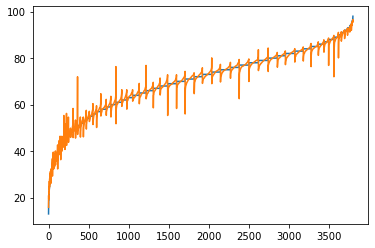

In [81]:
import seaborn as sns
#Visual Error observation:

a = y_train
p = rfr_synthesis.predict(X_train)
x = list(range(len(y_train)))

a1,p1 = zip(*sorted(zip(a,p)))

sns.lineplot(x,a1)
sns.lineplot(x,p1)

In [82]:
preds_mr

,critic_score_pred,user_score_pred,critic_score
0,8.2820,75.790,82.0
1,6.4150,55.470,53.0
2,7.9620,77.320,78.0
3,7.9910,71.950,73.0
4,8.0635,63.990,64.0
...,...,...,...
5062,8.2900,84.475,90.0
5063,7.1630,70.090,69.0
5064,7.4270,83.800,83.0
5065,7.1810,84.130,87.0


In [83]:
import shap

row_num = 1457

row = preds_mr.iloc[[row_num]]

explainer = shap.TreeExplainer(rfr_synthesis)
shap_values = explainer.shap_values(row)


observation = row[features]
actual = preds_mr.critic_score.iloc[row_num]
prediction = rfr_synthesis.predict(observation)

print(f'Actual Value= {actual}')
print(f'Prediction = {prediction[0]:,.02f}')
print(f'Error = {abs(prediction[0]-actual):,.02f}')

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row)


Actual Value= 83.0
Prediction = 81.98
Error = 1.02


I was having a lot of trouble with the "predict" function. this was because when I take iloc[] I get a pandas series I need to do iloc[[]] to get a pandas dataframe, and a pandas dataframe can be passed as a parameter to model.predict, but a series cannot, and throws up various errors, based on the state of the series. The code below shows how I finally figured it out.

In [84]:
#pandas Series
preds_mr.iloc[row_num]

critic_score_pred     7.054
user_score_pred      78.000
critic_score         83.000
Name: 1457, dtype: float64

In [85]:
#Pandas DataFrame
preds_mr.iloc[[row_num]]

,critic_score_pred,user_score_pred,critic_score
1457,7.054,78.0,83.0


In [86]:
#Pandas DataFrame without target
#At this state it is ready to go into model.predict()
preds_mr.iloc[[row_num]][features]

,critic_score_pred,user_score_pred
1457,7.054,78.0
